In [34]:
import numpy as np
from numpy import mean,std
from random import randint
import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D,add,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model,Model
from keras.backend import placeholder
from keras.initializers import glorot_uniform
from keras.utils import multi_gpu_model
from keras.metrics import RootMeanSquaredError
from keras.losses import MeanSquaredError
import h5py
from zipfile import ZipFile
import pydot
from numba import jit,cuda
import scipy
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.interpolation import map_coordinates

import scipy.io as sio
import itertools 


plt.rcParams["figure.figsize"] = (16,8)


Problem Statement: Estimate the State of Health of a Lithium -Ion Cell by using the test 

In [4]:
Capacity = h5py.File('Cap.mat','r')
Data_in = h5py.File('Age_Data.mat','r')
Data_in.keys()   

<KeysViewHDF5 ['#refs#', 'V_Q']>

In [5]:
Capacity = np.array(Capacity['Capacity']).T

Capacity[[0,3]] =  Capacity[[3,0]]
Capacity[[1,4]] = Capacity[[4,1]]
Capacity[[2,3]] = Capacity[[3,2]]
Capacity[[4,3]] = Capacity[[3,4]]
Capacity[[8,9]] = Capacity[[9,8]]
Capacity[[9,10]] = Capacity[[10,9]]

Cap_init = np.zeros((Capacity.shape[0],1))

for i in range(Capacity.shape[0]):
        
        Cap_init[i] = Capacity[i,0]
        
            

#Capacity = np.delete(Capacity,[19,39])
#Capacity = np.array(Capacity).reshape(2,1)

Capacity = Capacity.reshape(11*Capacity.shape[1],1)
#Cap_init_idx = np.nonzero(Cap_init)
#Cap_init = np.array(Cap_init[Cap_init_idx])

Cap_init = np.repeat(Cap_init,19)
#Cap_init = np.delete(Cap_init,[19,39])


Extract the input files from the data imported.

In [6]:
Checkups = np.array(Data_in['V_Q'])

In [7]:
Res = np.zeros((len(Checkups),18))
for i in range(len(Checkups)):
    
     Res[i,:] = np.array(Data_in['V_Q'][Checkups[i]]['Res']).T


In [8]:
Res_dis = Res[:,::2]
Res_dis.shape

(209, 9)

In [9]:
Res_crate = Res_dis[:,3:6]
Res_state = Res_dis[:,[0,3,6]]


In [10]:
Data_in['V_Q'][Checkups[1]].keys()

<KeysViewHDF5 ['Current', 'Res', 'SoC', 'Volt_Cap_discharge']>

In [11]:
FCE = np.arange(0,7600,400)

for i in range(10):
    if i == 0:
        FCE1 = np.append(FCE,FCE)
        
    else:
        FCE1 = np.append(FCE1,FCE)
    
FCE = np.array(FCE1)    
         
FCE = np.array(FCE).reshape(209,1)

In [12]:
Curr = np.array([23,46,92])
Curr1 = np.tile(Curr,627).reshape(9*209,1)

State = np.array([0.8,0.5,0.1])
State1 = np.tile(np.repeat(State,3),209).reshape(9*209,1)
FCE1  = np.repeat(FCE,9).reshape(9*209,1)


In [16]:
l = len(Capacity)
arr_shape = np.zeros((l,1))

for i in range(l):
    
    arr_shape[i] = np.array(Data_in['V_Q'][Checkups[i]]['Volt_Cap_discharge'][:,0].shape)

max_arr = int(np.max(arr_shape))


In [157]:
Xnew = np.zeros((l,2*max_arr))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['Volt_Cap_discharge'][:,1]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,2*max_arr)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    
    
Vt = np.round(Xnew,3)    
    
    

In [158]:
Xnew = np.zeros((l,100))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['Volt_Cap_discharge'][:,1]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,100)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    
    
Vt_soh = np.round(Xnew,3)    
    
    

In [159]:
Xnew = np.zeros((l,2*max_arr))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['Volt_Cap_discharge'][:,0]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,2*max_arr)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    Xnew[i,0] = 0.0
    
Cap = np.round(Xnew,3)   
   

In [160]:
Xnew = np.zeros((l,100))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['Volt_Cap_discharge'][:,0]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,100)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    
    
Cap_soh = np.round(Xnew,3)    
    
    

In [161]:
Xnew = np.zeros((l,2*max_arr))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['SoC'][:,0]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,2*max_arr)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    
    
SoC = np.round(Xnew,3)
SoC = np.round(1-SoC,3);
SoH = np.round(Cap[:]/23,3)   

In [162]:
Xnew = np.zeros((l,100))  
for i in range(l):
    x= np.array(Data_in['V_Q'][Checkups[i]]['SoC'][:,0]).T
    x= x.reshape(1,x.shape[0])
    new_dims = []
            
    for original_length, new_length in zip(x.shape, (1,100)):
        new_dims.append(np.linspace(0, original_length-1, new_length))

    
    coords = np.meshgrid(*new_dims, indexing='ij')
    Xnew[i,:] = map_coordinates(x, coords)
    
    
SoC_soh = np.round(Xnew,3)
SoC_soh = np.round(1-SoC_soh,3)
SoH_soh = np.round(Cap_soh[:]/23,3) 
SoH_soh[SoH_soh>1.0] =1.0

In [168]:
Res_dis1 = Res_dis.reshape(209*9,1)


Res_LuT = pd.concat((pd.DataFrame(FCE1),pd.DataFrame(Curr1),pd.DataFrame(State1),pd.DataFrame(Res_dis1)),axis = 1)
Res_LuT.columns = ['FCE','Curr','State','Res']
indexnames1 = Res_LuT[Res_LuT['Res'] >= 2.0].index

Res_LuT.drop(indexnames1 , inplace=True)

Res_dis1 = np.array(Res_LuT['Res'])
Res_LuT.drop(['Res'],axis = 1,inplace = True)

X_train,X_test,Y_train,Y_test = train_test_split(Res_LuT, Res_dis1, test_size=0.10, random_state=30)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=30)

minmax_scaler = preprocessing.RobustScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.fit_transform(X_test)
X_val_scaled = minmax_scaler.fit_transform(X_val)

In [169]:
np.random.seed(1)


model = Sequential()
model.add(Dense(60,input_dim = 3,activation = 'sigmoid',kernel_initializer='glorot_uniform'))  # input and 1st layer
model.add(Dense(80,activation = 'relu',kernel_initializer='glorot_uniform')) #2nd layer
model.add(Dense(20,activation = 'relu',kernel_initializer='glorot_uniform')) #2nd layer

model.add(Dense(1,activation = 'linear',kernel_initializer='glorot_uniform')) # output layer
adam = Adam(lr=0.007)
model.compile(loss= MeanSquaredError(),optimizer = adam,metrics = [RootMeanSquaredError()])

history = model.fit(X_train_scaled,Y_train,epochs = 100,batch_size = 64)
plt.plot(history.history['loss'])
model.save('model_DNN_SoH.h5')


ValueError: Error when checking target: expected dense_59 to have shape (3,) but got array with shape (1,)

SoC vs Voltage Curves are Drawn to assess the behavior of the cell voltage w.r.t ageing of the cell.

1195/1195 [==============================] - 1s 1ms/step
rmse : 0.11254475265741348
0.700569038712006


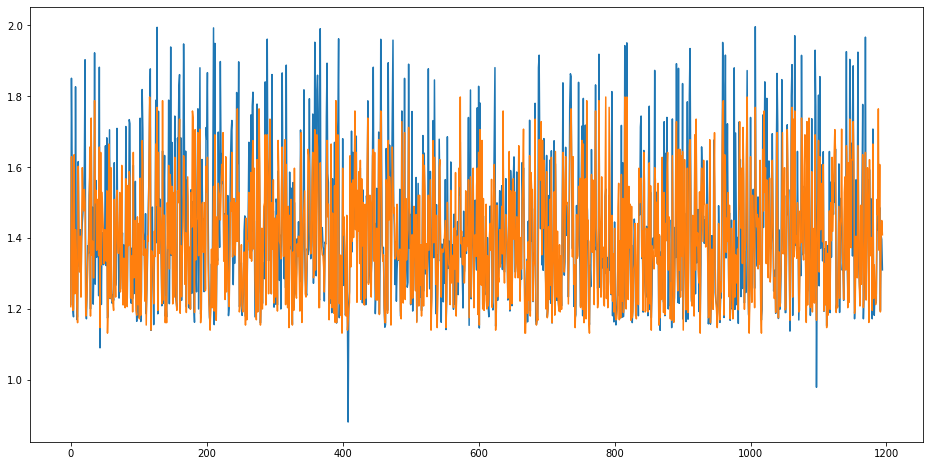

In [2004]:
_,rmse = model.evaluate(X_train_scaled,Y_train)
print('rmse :',(rmse))


predictions = model.predict(X_train_scaled);
R2 = r2_score(Y_train,predictions)
print(R2)
plt.plot(Y_train[0:])
plt.plot(predictions[0:])


399/399 [==============================] - 0s 245us/step
Val rmse : 0.12397810071706772
0.6612104904118024


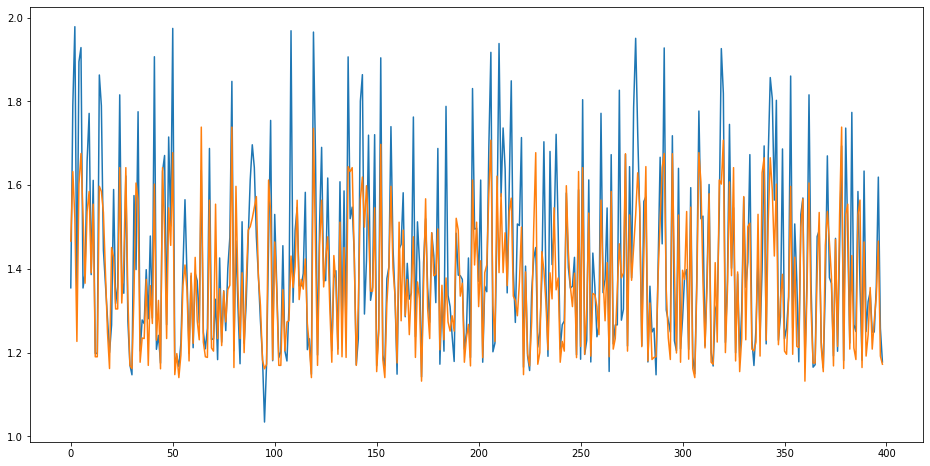

In [2005]:
# Validation performance
_,rmse = model.evaluate(X_val_scaled,Y_val)
print('Val rmse :',(rmse))

predictions = model.predict(X_val_scaled);
R2 = r2_score(Y_val,predictions)
print(R2)
plt.plot(Y_val)
plt.plot(predictions)

178/178 [==============================] - 0s 216us/step
Test rmse : 0.16029536724090576
0.5046592390932985


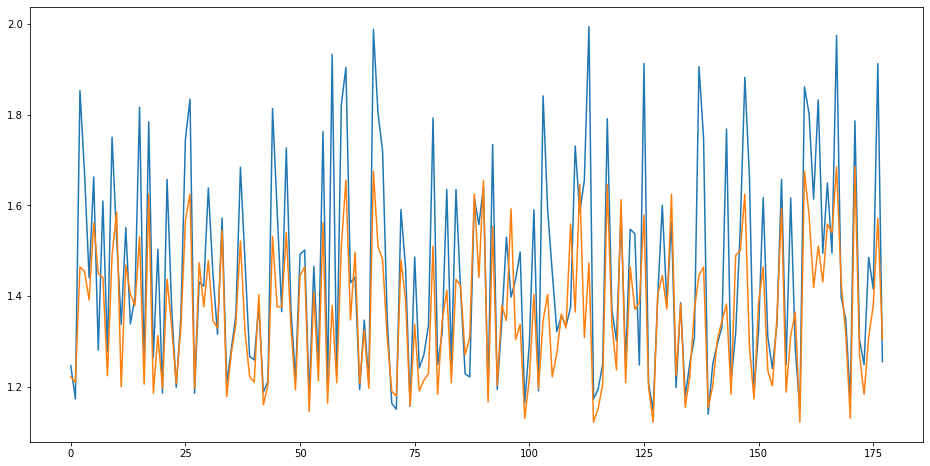

In [2006]:
# test performance
_,rmse = model.evaluate(X_test_scaled,Y_test)
print('Test rmse :',(rmse))

predictions = model.predict(X_test_scaled);
R2 = r2_score(Y_test,predictions)
print(R2)
plt.plot(Y_test)
plt.plot(predictions)

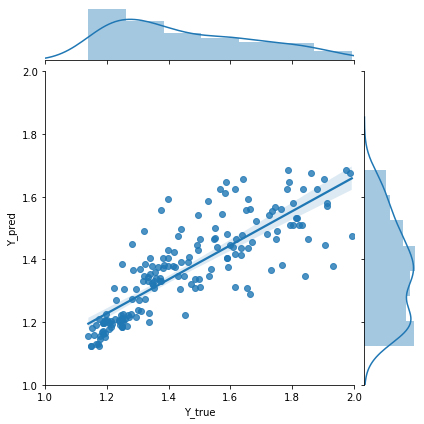

In [2007]:
Test_set = pd.concat((pd.DataFrame(Y_test),pd.DataFrame(predictions)),axis = 1)
Test_set.columns = ['Y_true','Y_pred']
sns.jointplot('Y_true', 'Y_pred', Test_set,kind = 'reg',xlim = [1,2],ylim = [1,2])


In [1830]:
newdata = minmax_scaler.fit_transform(np.array([5000,46,0.8]).reshape(1,3))
pred_new = model.predict(newdata)
print(pred_new)

[[1.3727919]]


OCV voltage from the internal resistance calculated. Here the resistance is measured as a R10s which is calculated from the characterisation tests to measure the pulse resistances. This includes the ohmic resitances and the chargetransfer resistance. 
R10s = R0 + Rct

Vocv = Vt + R10s

Similarly from the capacity values, the state of charge and state of health  are calculated.

Reshape the SoC,SoH,Vocv,CellVolt arrays as column arrays in order to feed them into Neural Networks


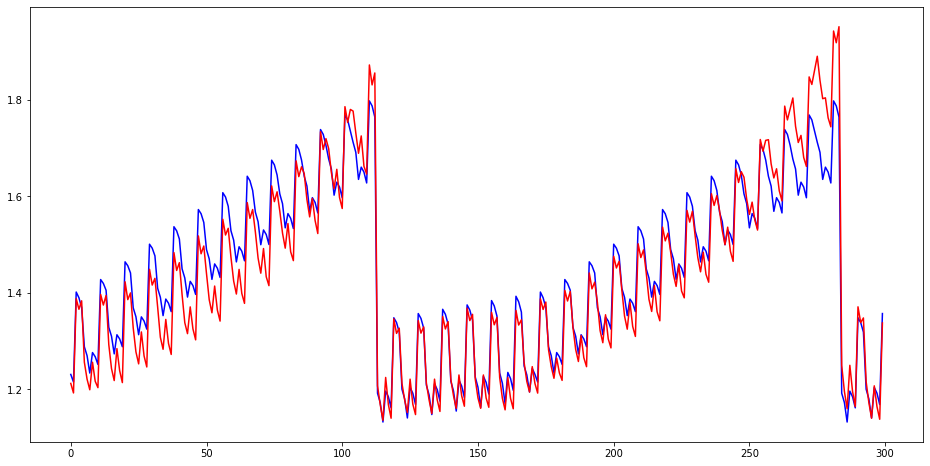

In [2008]:
predictions = model.predict(minmax_scaler.fit_transform(np.array(Res_LuT)));
plt.plot(predictions[400:700],'b')
plt.plot(Res_dis1[400:700],'r')

In [1921]:
res_pred = np.zeros((Res_dis1.shape))
Res_in = np.array(Res_LuT).reshape(Res_dis1.shape[0],3)
Data_in = pd.DataFrame(Res_in,index = np.arange(0,Res_dis1.shape[0]))
Data_in.columns = ['FCE','Curr','State']
Data_Scaled = (minmax_scaler.fit_transform(Data_in))

for i in range(Res_dis1.shape[0]):
    x = Data_Scaled[i,:].reshape(1,3)
    res_pred[i] = model.predict(x)
    print(res_pred[i])
    

1.1807664632797241
1.1618553400039673
1.1236754655838013
1.2129629850387573
1.1935738325119019
1.1629462242126465
1.355838418006897
1.3413548469543457
1.3158860206604004
1.1903210878372192
1.1713764667510986
1.1330024003982544
1.2180882692337036
1.1987073421478271
1.1689963340759277
1.3630298376083374
1.3485316038131714
1.3237303495407104
1.1999435424804688
1.1809743642807007
1.1424239873886108
1.2233487367630005
1.203985333442688
1.1760923862457275
1.3702536821365356
1.3560211658477783
1.331620693206787
1.2096271514892578
1.1906423568725586
1.1519343852996826
1.2288265228271484
1.2102177143096924
1.1836974620819092
1.3775017261505127
1.3639774322509766
1.3395476341247559
1.219365119934082
1.2003741264343262
1.1615269184112549
1.2353856563568115
1.2173669338226318
1.1915701627731323
1.3847661018371582
1.3719534873962402
1.3475029468536377
1.2291502952575684
1.21016263961792
1.1712650060653687
1.2421507835388184
1.22481369972229
1.1995999813079834
1.392549991607666
1.3799402713775635
1.

1.3948185443878174
1.37954843044281
1.5653260946273804
1.5624654293060303
1.5538091659545898
1.4659639596939087
1.455048680305481
1.4285919666290283
1.4409449100494385
1.435821533203125
1.4201239347457886
1.601318597793579
1.5983364582061768
1.588407039642334
1.50437331199646
1.4946359395980835
1.4674668312072754
1.4816371202468872
1.4761831760406494
1.4600138664245605
1.6366455554962158
1.6333997249603271
1.6220957040786743
1.5432448387145996
1.5339370965957642
1.5060945749282837
1.5215580463409424
1.5159127712249756
1.498838186264038
1.6710909605026245
1.667728066444397
1.655215859413147
1.5824750661849976
1.5729252099990845
1.5444483757019043
1.5611261129379272
1.5552945137023926
1.5368740558624268
1.7049717903137207
1.7016135454177856
1.6879323720932007
1.6213526725769043
1.6115732192993164
1.5823458433151245
1.600306510925293
1.5942940711975098
1.5745651721954346
1.7382607460021973
1.7349213361740112
1.7202296257019043
1.659850835800171
1.6498547792434692
1.6197679042816162
1.6390

1.2512538433074951
1.2272751331329346
1.4181907176971436
1.4158015251159668
1.409369707107544
1.3076382875442505
1.295989751815796
1.2682130336761475
1.2854230403900146
1.2735857963562012
1.2631686925888062
1.4553741216659546
1.4528701305389404
1.4459848403930664
1.3475207090377808
1.3357045650482178
1.308678150177002
1.3172792196273804
1.3116282224655151
1.2990498542785645
1.4923168420791626
1.4896957874298096
1.482358694076538
1.3872324228286743
1.37516188621521
1.3489930629730225
1.3582706451416016
1.3533353805541992
1.3387463092803955
1.528980016708374
1.5262399911880493
1.518454909324646
1.426722764968872
1.4146387577056885
1.3890647888183594
1.399733304977417
1.3948185443878174
1.37954843044281
1.5653260946273804
1.5624654293060303
1.5538091659545898
1.455048680305481
1.4285919666290283
1.4409449100494385
1.435821533203125
1.4201239347457886
1.1807664632797241
1.1618553400039673
1.1236754655838013
1.2129629850387573
1.1935738325119019
1.1629462242126465
1.355838418006897
1.341354

1.3582706451416016
1.3533353805541992
1.3387463092803955
1.528980016708374
1.5262399911880493
1.518454909324646
1.426722764968872
1.4146387577056885
1.3890647888183594
1.399733304977417
1.3948185443878174
1.37954843044281
1.5653260946273804
1.5624654293060303
1.5538091659545898
1.4659639596939087
1.455048680305481
1.4285919666290283
1.4409449100494385
1.435821533203125
1.4201239347457886
1.601318597793579
1.5983364582061768
1.588407039642334
1.50437331199646
1.4946359395980835
1.4674668312072754
1.4816371202468872
1.4761831760406494
1.4600138664245605
1.6366455554962158
1.6333997249603271
1.6220957040786743
1.5432448387145996
1.5339370965957642
1.5060945749282837
1.5215580463409424
1.5159127712249756
1.498838186264038
1.6710909605026245
1.667728066444397
1.655215859413147
1.5824750661849976
1.5729252099990845
1.5444483757019043
1.5611261129379272
1.5552945137023926
1.5368740558624268
1.7049717903137207
1.7016135454177856
1.6879323720932007
1.6213526725769043
1.6115732192993164
1.582345

In [1922]:
New = np.array([[2210,20,0.5],[450,40,0.7],[234,60,0.2],[7100,23,0.5],[745,35,0.45]])
NewData = New
#NewData = np.array([900,30,0.6]).reshape(1,3);
NewData = pd.DataFrame(NewData)
NewData_Scaled = (minmax_scaler.fit_transform(NewData))
New_pred = np.zeros((NewData.shape[0],1))
for i in range(NewData_Scaled.shape[0]):
    x= NewData_Scaled[i,:].reshape(1,3)
    New_pred[i] = model.predict(x)
    
New_pred

array([[1.2379179 ],
       [1.15768051],
       [1.31588602],
       [1.67509151],
       [1.21413994]])

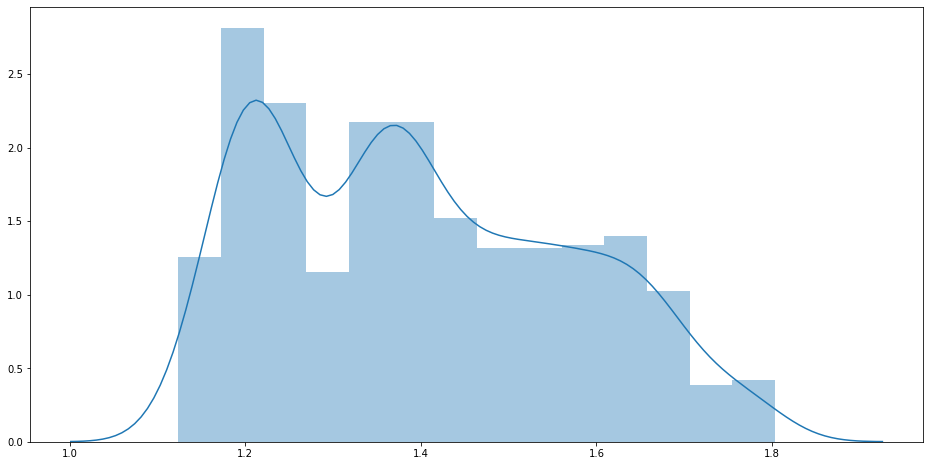

In [1923]:
sns.distplot(res_pred)

In [1855]:
SoC.shape

(209, 7792)

In [1858]:
np.concatenate((FCE,SoC),axis =1).shape

(209, 7793)

In [1924]:
Ri = np.zeros((SoC.shape))
I = 23

for i in range(1):
    print(i)
    for j in range(0,SoC.shape[1]): 
        Data_i = np.array([FCE[i],I,SoC[i,j]],dtype = 'float64')
        Data_i_pd = pd.DataFrame(Data_i) 
        Data_i_scaled = minmax_scaler.fit_transform(Data_i_pd)
        Data_i_scaled = Data_i_scaled.reshape(1,3)
        Ri[i,j] = model.predict(Data_i_scaled)
        
    

0


In [1925]:
r = Ri

In [24]:

SOC = SoC.ravel().reshape(-1,1)
V_meas = Vt.ravel().reshape(-1,1)
I = 23*np.ones(V_meas.shape)
P = V_meas*I



In [72]:
NN_inp = pd.concat((pd.DataFrame(V_meas),pd.DataFrame(P),pd.DataFrame(I)),axis = 1)
NN_inp.columns = ['Volt','Power','I']

X_train,X_test,Y_train,Y_test =  train_test_split(NN_inp, SOC, test_size=0.10, random_state=30)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=30)

Scaler = preprocessing.RobustScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.fit_transform(X_test)
X_val_scaled = Scaler.fit_transform(X_val)

Epoch 1/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 0.0028 - root_mean_squared_error: 0.0525
Epoch 2/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 4.4009e-04 - root_mean_squared_error: 0.0210
Epoch 3/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 4.6620e-04 - root_mean_squared_error: 0.0216
Epoch 4/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 4.7407e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 4.7501e-04 - root_mean_squared_error: 0.0218
Epoch 6/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 4.2350e-04 - root_mean_squared_error: 0.0206
Epoch 7/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 3.1781e-04 - root_mean_squared_error: 0.0178
Epoch 8/10
1319107/1319107 [==============================] - 5s 4us/step - loss: 3.1531e-04 - root_mean_squared_er

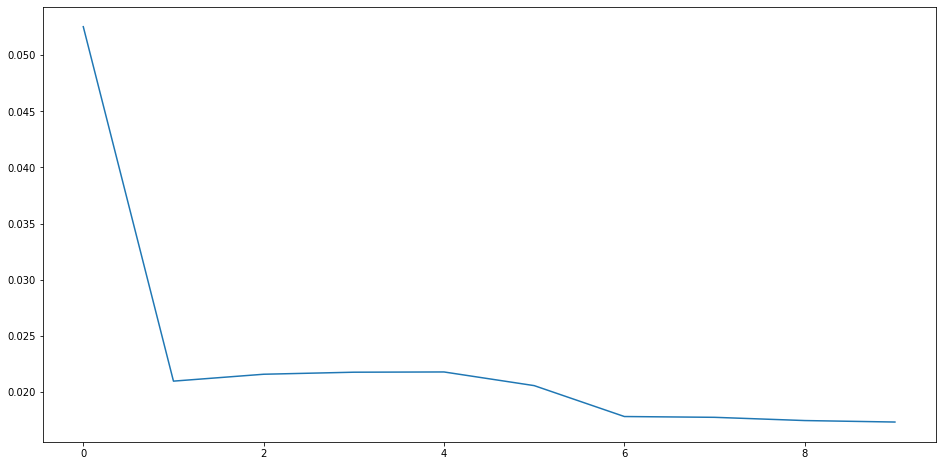

In [83]:
np.random.seed(1)


model = Sequential()
model.add(Dense(3,input_dim = 3,activation = 'sigmoid',kernel_initializer='glorot_uniform'))  # input and 1st layer
model.add(Dense(5,activation = 'relu',kernel_initializer='glorot_uniform')) #2nd layer

model.add(Dense(1,activation = 'linear',kernel_initializer='glorot_uniform')) # output layer
adam = Adam(lr=0.07)
model.compile(loss= MeanSquaredError(),optimizer = adam,metrics = [RootMeanSquaredError()])

history = model.fit(X_train_scaled,Y_train,epochs = 5,batch_size = 1024)
plt.plot(history.history['root_mean_squared_error'])
model.save('model_FFNN_SoH.h5')


In [84]:
_,rmse = model.evaluate(X_train_scaled,Y_train)
print('rmse :',(rmse))


predictions = model.predict(X_train_scaled);
R2 = r2_score(Y_train,predictions)
print(R2)

1319107/1319107 [==============================] - 43s 33us/step
rmse : 0.016713744029402733
0.9977416655231827


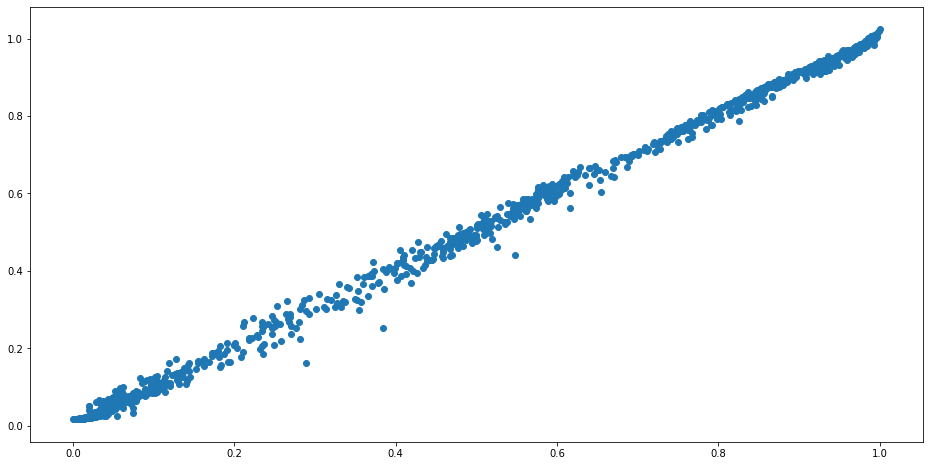

In [85]:
plt.scatter(Y_train[:1000],predictions[:1000])

In [86]:
#validation performance

_,rmse = model.evaluate(X_val_scaled,Y_val)
print('rmse :',(rmse))


predictions = model.predict(X_val_scaled);
R2 = r2_score(Y_val,predictions)
print(R2)

146568/146568 [==============================] - 5s 37us/step
rmse : 0.016734952107071877
0.9977392126403386


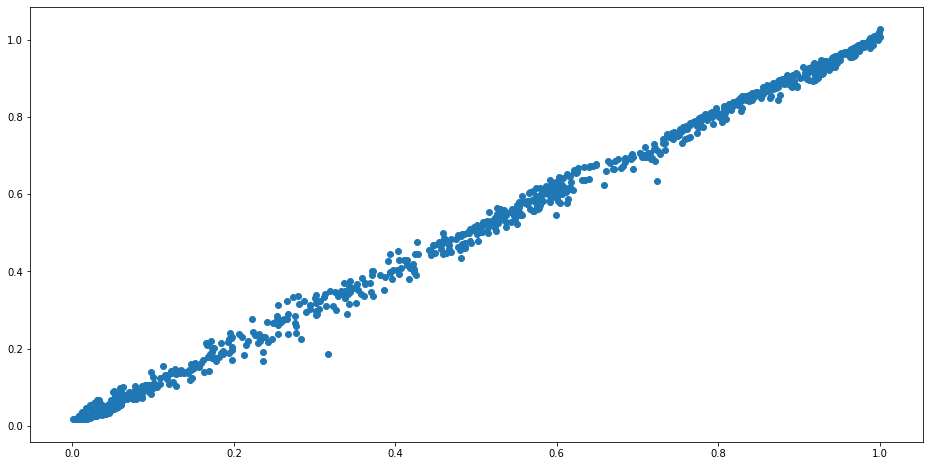

In [87]:
plt.scatter(Y_val[:1000],predictions[:1000])

In [89]:
#test performance

_,rmse = model.evaluate(X_test_scaled,Y_test)
print('rmse :',(rmse))


predictions = model.predict(X_test_scaled);
R2 = r2_score(Y_test,predictions)
print(R2)

162853/162853 [==============================] - 7s 40us/step
rmse : 0.016590362414717674
0.997773133811086


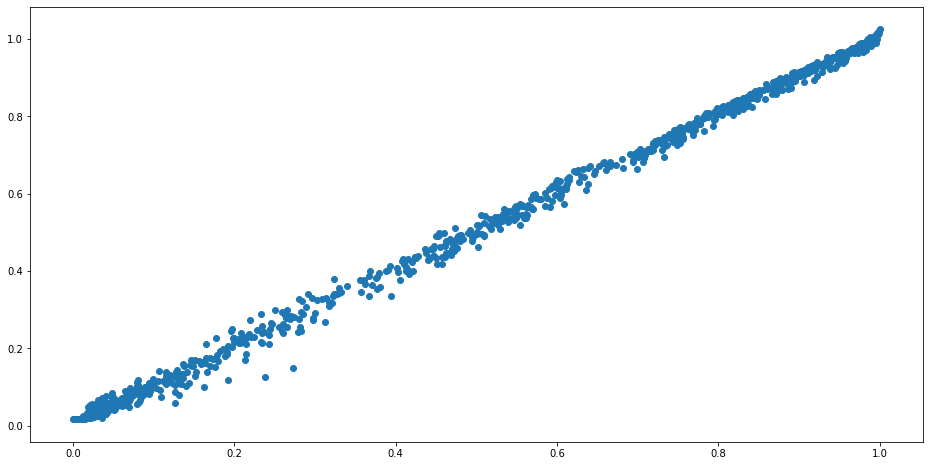

In [90]:
plt.scatter(Y_test[:1000],predictions[:1000])

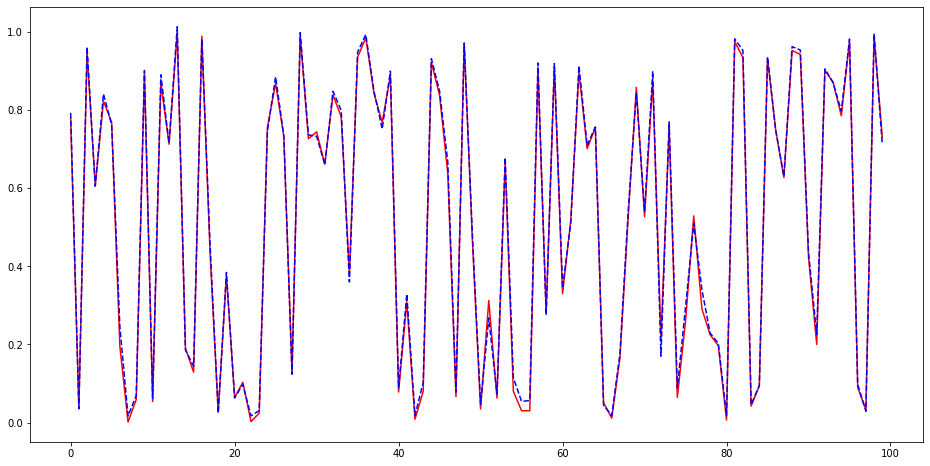

In [91]:
plt.plot(Y_test[:100],'r')
plt.plot(predictions[:100],'--b')

In [92]:
X_scaled = Scaler.fit_transform(NN_inp)
_,rmse = model.evaluate(X_scaled,SOC)
predictions = model.predict(X_scaled)
R2 = r2_score(SOC,predictions)
print(R2)

1628528/1628528 [==============================] - 52s 32us/step
0.9977448531112244


In [93]:
R2 = r2_score(SOC,predictions)
print(R2)

0.9977448531112244


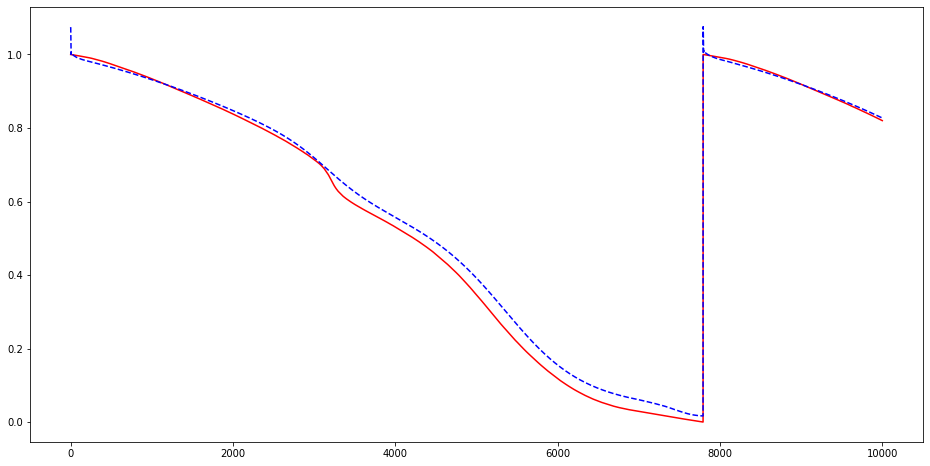

In [94]:
plt.plot(SOC[:10000],'r')
plt.plot(predictions[:10000],'--b')

In [120]:
print(Cap_soh.shape)
print(Vt_soh.shape)
print(SoC_soh.shape)
print(SoH_soh.shape)


(209, 100)
(209, 100)
(209, 100)
(209, 100)


In [180]:
Cap_ex = Cap[0:19,:]
Vt_ex = Vt[0:19,:]
FCE_ex = FCE[0:19,:] 


In [184]:
soh = (Cap_ex[:,-1])/Cap_ex[0,-1]

In [195]:
soh

array([1.        , 0.99543457, 0.98178094, 0.97294876, 0.9626232 ,
       0.9560524 , 0.94794556, 0.93860136, 0.9327559 , 0.9173529 ,
       0.91027009, 0.90318727, 0.90109656, 0.89764048, 0.89426974,
       0.88914964, 0.88650425, 0.88202415, 0.87980544])